## Finance Project

### Get data of HSI via Yahoo API

In [34]:
import yfinance as yf
import pandas as pd
import numpy as np

df_raw = yf.download("^HSI", start="1987-01-01", end="2023-01-01")
print(df_raw.tail(3))

[*********************100%%**********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2022-12-28  19787.939453  20099.769531  19787.939453  19898.910156   
2022-12-29  19648.400391  19764.519531  19539.839844  19741.140625   
2022-12-30  20030.849609  20073.919922  19781.410156  19781.410156   

               Adj Close      Volume  
Date                                  
2022-12-28  19898.910156  2823780600  
2022-12-29  19741.140625  2902362900  
2022-12-30  19781.410156  1747706800  


In [35]:
# check data info
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8890 entries, 1987-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       8890 non-null   float64
 1   High       8890 non-null   float64
 2   Low        8890 non-null   float64
 3   Close      8890 non-null   float64
 4   Adj Close  8890 non-null   float64
 5   Volume     8890 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 486.2 KB


In [36]:
# Data Cleaning
# Remove the last two columns
data = df_raw.copy().drop(columns = ['Adj Close','Volume']).dropna()
data.tail(3)

,Open,High,Low,Close
Date,,,,
2022-12-28,19787.939453,20099.769531,19787.939453,19898.910156
2022-12-29,19648.400391,19764.519531,19539.839844,19741.140625
2022-12-30,20030.849609,20073.919922,19781.410156,19781.410156


#### Add features
Moving average, MA is a concept for analysing the trend in certain period.  

Simple returns is the weighted sum of the returns of the individual assets in the portfolio.  

Log returns for a given month is the sum of the log returns of the days
within that month. It provides a more accurate measure of the % change in the value of ab asset over a period of time.

Volatility to measure asset risk, it is the degree of variation of a trading price series over time.

In [37]:
def add_features(feats):
    for i in [20,60]:
        feats[f"NA_{i}"] = (feats["Close"].rolling(i).mean())
    feats['simple_rtn'] = feats.Close.pct_change()
    # .pct_change() calculate the % change
    # eg [2,3,6].pct_change() = [NaN,0.5,1]
    feats['log_rtn'] = np.log(feats.Close/feats.Close.shift(1))
    feats['volatility_20'] = (np.log(
        feats["Close"]).diff().rolling(20).std())
    feats['log_rtn_20'] = np.log(feats.Close/feats.Close.shift(20))
    return feats
data = add_features(data).dropna()
print(data.tail(3))

                    Open          High           Low         Close  \
Date                                                                 
2022-12-28  19787.939453  20099.769531  19787.939453  19898.910156   
2022-12-29  19648.400391  19764.519531  19539.839844  19741.140625   
2022-12-30  20030.849609  20073.919922  19781.410156  19781.410156   

                   NA_20         NA_60  simple_rtn   log_rtn  volatility_20  \
Date                                                                          
2022-12-28  19283.545996  17576.418148    0.015610  0.015490       0.021549   
2022-12-29  19360.369043  17620.778662   -0.007929 -0.007960       0.019096   
2022-12-30  19419.578027  17649.002653    0.002040  0.002038       0.018659   

            log_rtn_20  
Date                    
2022-12-28    0.140078  
2022-12-29    0.081026  
2022-12-30    0.061730  


In [38]:
# Plot graph
# log Return is additive,
# can use the sum of the log returns for each asset.
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
colors = px.colors.qualitative.Plotly
fig = make_subplots(rows=3, cols=1, shared_xaxes=True)
for i, j in enumerate([data.simple_rtn, data.log_rtn, data.Close]):
    fig.add_trace(go.Scatter(x=data.index, y=j, mode='lines',
                             name=j.name, marker_color=colors[i]), 
                  row=i+1, col=1)
fig.show()

#### Detecting Outliers using the 3std approach 

In [39]:
# calculate mean and std from the simple_return column
df_rolling = data[['simple_rtn']].rolling(20).agg(['mean','std'])
# rolling() moving window, agg() apply function to specified axis
df_rolling.columns = df_rolling.columns.droplevel()
# droplevel() removes the specifed rows or columns
df_outliers = data.join(df_rolling)

In [40]:
# outliers of 3 std dv
def identify_outliers(row, n_sigmas=3):
    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']
    if (x > mu + 3 * sigma) | (x < mu -3 * sigma):
        return 1
    else:
        return 0
    # sigma is standard deviation

In [41]:
df_outliers['outlier'] = df_outliers.apply(identify_outliers, axis = 1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1, ['simple_rtn']]
outliers.tail(5)

,simple_rtn
Date,
2016-09-12,-0.033573
2018-02-06,-0.051164
2019-05-06,-0.028979
2022-03-16,0.090818
2022-10-05,0.059045


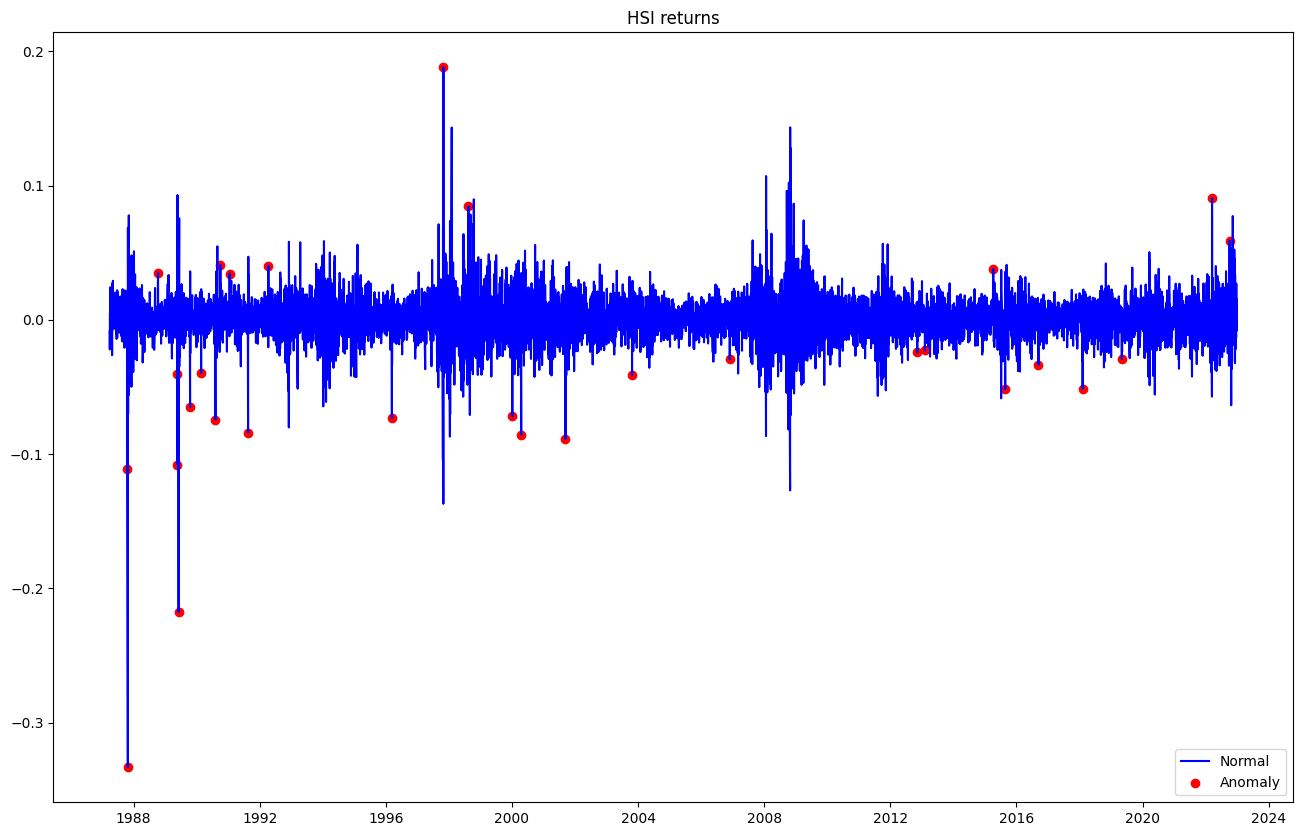

In [42]:
# plot graph
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(df_outliers.index, df_outliers.simple_rtn, color='blue', 
        label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, color='red', 
           label='Anomaly')
ax.set_title("HSI returns")
ax.legend(loc='lower right')
plt.show()

In [43]:
data.describe()

,Open,High,Low,Close,NA_20,NA_60,simple_rtn,log_rtn,volatility_20,log_rtn_20
count,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000
mean,15618.668241,15720.067730,15497.632051,15612.443663,15594.402424,15560.239481,0.000355,0.000221,0.013847,0.004399
std,8078.948998,8121.273706,8020.202788,8070.968662,8068.342257,8065.845157,0.016228,0.016450,0.008838,0.075487
min,1950.500000,1950.500000,1894.900024,1894.900024,2085.339990,2220.491661,-0.333304,-0.405420,0.003966,-0.700236
25%,9494.599609,9569.250000,9416.470215,9493.165039,9471.997485,9499.276693,-0.006752,-0.006775,0.008813,-0.032728
50%,15075.780273,15192.919922,14936.900391,15070.559570,15058.706934,15019.605973,0.000551,0.000551,0.011381,0.009794
75%,22697.649414,22808.315430,22541.815430,22668.540039,22601.260791,22643.067643,0.007985,0.007953,0.015852,0.048447
max,33335.480469,33484.078125,32897.039062,33154.121094,32213.191504,31275.259961,0.188236,0.172470,0.100805,0.328689


In [44]:
import scipy.stats as scs
# compare the log return distribution with a normal distribution
# Probability Density function using the mean and standard deviation
# of the observed returns
r_range = np.linspace(min(data.log_rtn), max(data.log_rtn), num=8831)
# 8831 is the total count
# linspace to create anevenly spaced sequence in a specified interval
mu = data.iloc[-250:].log_rtn.mean()
sigma = data.iloc[-250:].log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)
# norm_pdf returns the probability density function at each of the
# values in X using the normal distribution with mean mu and standard
# deviation sigma

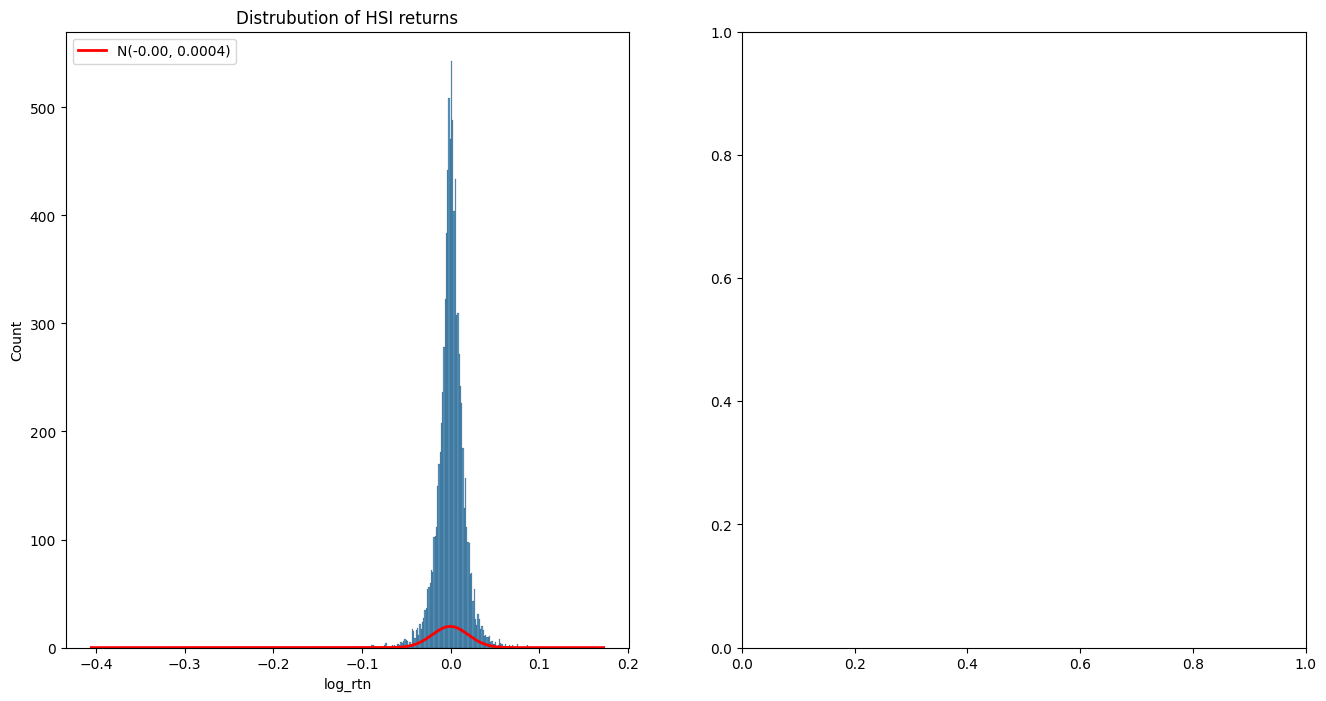

In [45]:
# plot graph
fig, ax = plt.subplots(1,2,figsize=(16, 8))
# Histogram
ax[0].set_title('Distrubution of HSI returns')
sns.histplot(data = data, x= 'log_rtn', kde = False, ax = ax[0])
ax[0].plot(r_range, norm_pdf, 'r', lw=2, 
           label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left')
# Q-Q plot
# qq = sm.qqplot(data.log_rtn.values, line='s', ax=ax[1])
# ax[1].set_title('Q-Q plot', fontsize = 16)
plt.show()

In [46]:
# using last 250 days sample

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



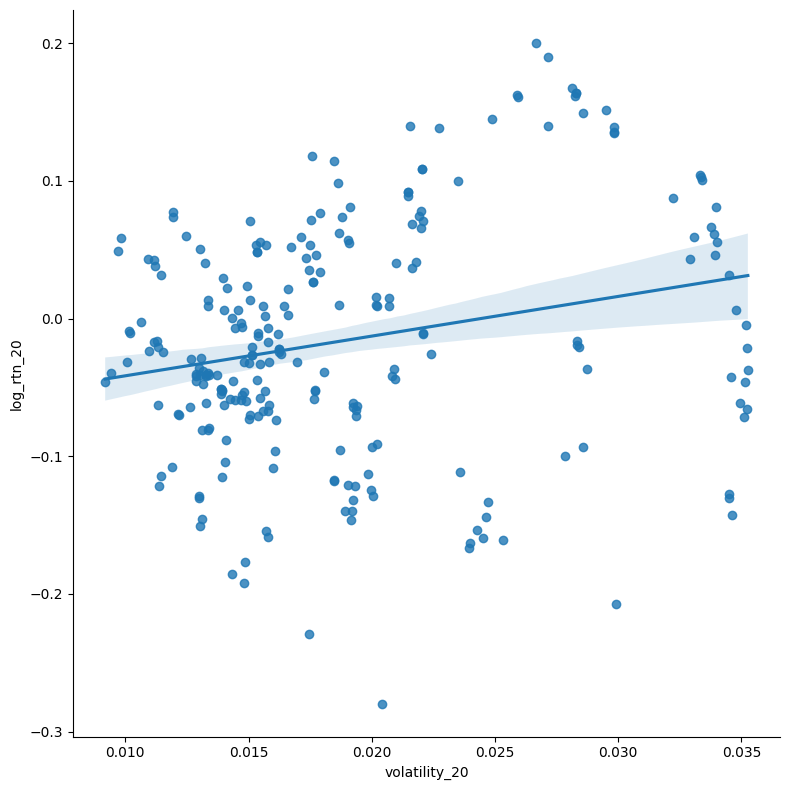

In [47]:
# Log return vs Volatility (Risk)
# Volatility or Standard Deviation means Risk in Finance
sns.lmplot(data=data.iloc[-250:], x = "volatility_20",
           y = "log_rtn_20", height = 8)

In [48]:
# Correlation - relation of 2 matters in same time series
AA = data.iloc[-250:].volatility_20.corr(data.iloc[-250:].log_rtn_20)
print('Correlation between return and volatility is',AA)

Correlation between return and volatility is 0.22993256556828845


In [49]:
# Auto Correlation - relation of current and past
BB = data.iloc[-250:].log_rtn.autocorr(lag=1)
print("Autocorrelation of log return inlast 250-days",BB)

Autocorrelation of log return inlast 250-days 0.05060587450032967


#### Shape Ratio

Sharpe Ratio is net return on unit risk

In [63]:
petroC = yf.download("0857.HK", start = "2022-01-01", end = "2023-07-01")
print(petroC.head(3))
hsbc = yf.download("0005.HK", start = "2022-01-01", end = "2023-07-01")
print(hsbc.head(3))

[*********************100%%**********************]  1 of 1 completed
            Open  High   Low  Close  Adj Close    Volume
Date                                                    
2022-01-03  3.47  3.51  3.45   3.48   2.916195  36654422
2022-01-04  3.51  3.51  3.43   3.46   2.899435  60100797
2022-01-05  3.48  3.54  3.44   3.51   2.941334  84686482
[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2022-01-03  47.000000  47.150002  46.650002  46.849998  43.402561   6711558
2022-01-04  47.099998  47.799999  47.000000  47.799999  44.282654  25500155
2022-01-05  49.349998  49.750000  48.750000  49.150002  45.533318  59292303


In [64]:
def cal_sharpe(df):
    rf_rate = 0.01 # assume risk free rate = 0.01
    log_ret_annual = np.log(df.Close[df.index[-1]]/df.Close[df.index[0]])
    df['log_ret_daily'] = np.log(df.Close/df.Close.shift(1))
    df = df.dropna()
    sharpe = (log_ret_annual - rf_rate)/df.log_ret_daily.std()
    return f"Sharpe Ratio: {sharpe:.4f}, Annual Log Return: {log_ret_annual:.4f}"

In [65]:
print("HSBC", cal_sharpe(hsbc))
print("petroC", cal_sharpe(petroC))
# the higher the Sharpe ratio, the more attractive the return and 
# the better the investment.
# if negative Sharpe ratio, it means one of two things:
# either the risk-free rate is greater than the portfolio's return,
# or the portfolio should anticipate a negative return

HSBC Sharpe Ratio: 14.0254, Annual Log Return: 0.2639
petroC Sharpe Ratio: 21.7574, Annual Log Return: 0.4431


https://data.gov.hk/tc/

#### Old Data

In [53]:
from decimal import ROUND_HALF_UP, Decimal
from tqdm import tqdm
import statsmodels.api as sm




